In [1]:
# plotting stuff
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import cartopy.crs as crs

# built in python modules
import datetime
import os
import inspect
import sys

# python add-ons
import numpy as np
import pandas as pd
import scipy
import xarray as xr
import netCDF4
from wrf import (to_np, getvar, ALL_TIMES, smooth2d, get_cartopy, cartopy_xlim,
                 cartopy_ylim, latlon_coords)
import xesmf as xe
import optwrf as ow
from optwrf import runwrf as rw

/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/pvlib-python/pvlib/wrfcast.py:20: UserWarning: The forecast module algorithms and features are highly experimental. The API may change, the functionality may be consolidated into an io module, or the module may be separated into its own package.
  'The forecast module algorithms and features are highly experimental. '


In [2]:
# The following function is an ad-hoc fix that changes out-of-original-grid values from zero to NaN.
def add_matrix_NaNs(regridder):
    X = regridder.weights
    M = scipy.sparse.csr_matrix(X)
    num_nonzeros = np.diff(M.indptr)
    M[num_nonzeros == 0, 0] = np.NaN
    regridder.weights = scipy.sparse.coo_matrix(M)
    return regridder

In [3]:
param_ids = [10, 1, 1, 2, 2, 3, 2]
start_date = 'Feb 7  2011'
end_date = 'Feb 8 2011'
wrf_sim = rw.WRFModel(param_ids, start_date, end_date, 
                      setup_yaml='/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/met4ene/optwrf/optwrf/data/mac_dirpath.yml') 

Forecast starting on: 2011-02-07 00:00:00
Forecast ending on: 2011-02-08 00:00:00


In [4]:
# Process the ERA5 data
wrf_sim.process_era5_data()

In [5]:
# Find the path to optwrf
optwrf_path = os.path.dirname(os.path.abspath(inspect.getfile(ow)))

In [6]:
in_yr = 2011
in_mo = 2
wrfdir = os.path.join(optwrf_path, 'data/')
eradir = wrf_sim.DIR_ERA5_ROOT

The xESMF regridder docs are located at: https://xesmf.readthedocs.io/en/latest/notebooks/Curvilinear_grid.html

In [7]:
# WRF file containing source grid
wrffile = 'wrfout_processed_d01.nc'
try:
    wrfdata = xr.open_dataset(wrfdir + wrffile)
except FileNotFoundError:
    print(f'The wrfout file {wrfdir + wrffile} does not exist. Check that your path.')

# Get wrf variable(s) to regrid
# wrf_lat = wrfdata.XLAT
# wrf_lon = wrfdata.XLONG
# wrfdata = wrfdata.rename({'XLONG': 'lon', 'XLAT': 'lat'})

# Read in and convert GHI from W m-2 to kW m-2
ghi = wrfdata.ghi
ghi = ghi/1000

# Read in WPD, convert from W m-2 to kW m-2
wpd = wrfdata.wpd
wpd = wpd/1000

wrfdata

<xarray.Dataset>
Dimensions:         (Time: 24, bottom_top: 35, south_north: 191, west_east: 191)
Coordinates:
  * Time            (Time) datetime64[ns] 2011-02-07 ... 2011-02-07T23:00:00
    lon             (south_north, west_east) float32 ...
    lat             (south_north, west_east) float32 ...
    wspd_wdir       object ...
    XLONG           (south_north, west_east) float32 ...
    XLAT            (south_north, west_east) float32 ...
    XTIME           (Time) float32 ...
    level           int64 ...
Dimensions without coordinates: bottom_top, south_north, west_east
Data variables:
    Times           (Time) datetime64[ns] ...
    temp_air        (Time, south_north, west_east) float32 ...
    wind_speed_u    (Time, south_north, west_east) float32 ...
    wind_speed_v    (Time, south_north, west_east) float32 ...
    cloud_fraction  (Time, bottom_top, south_north, west_east) float32 ...
    cos_zenith      (Time, south_north, west_east) float32 ...
    dni             (Time, south_north, west_east) float32 ...
    dhi             (Time, south_north, west_east) float32 ...
    ghi             (Time, south_north, west_east) float32 0.0 0.0 ... 0.0 0.0
    wind_speed10    (Time, south_north, west_east) float32 ...
    wind_speed100   (Time, south_north, west_east) float32 ...
    wpd             (Time, south_north, west_east) float32 29141.006 ... 7670.802

In [8]:
# ERA data file(s)
erafile = f'ERA5_EastUS_WPD-GHI_{str(in_yr).zfill(4)}-{str(in_mo).zfill(2)}.nc'
try:
    eradata = xr.open_dataset(eradir + erafile)
except FileNotFoundError:
    print(f'The wrfout file {eradir + erafile} does not exist. Check that your path.')

# Get variables to compare with regridded WRF variables.
# era_lat = eradata.latitude
# era_lon = eradata.longitude
eradata = eradata.rename({'longitude': 'lon', 'latitude': 'lat'})

# Read in ERA_GHI, convert from W m-2 to kW m-2
era_ghi = eradata.GHI
era_ghi = era_ghi / 1000

# Read in ERA_WPD, convert from W m-2 to kW m-2
era_wpd = eradata.WPD
era_wpd = era_wpd / 1000

# Write these back to the xarray dataset
eradata['ghi'] = era_ghi
eradata['wpd'] = era_wpd

eradata

<xarray.Dataset>
Dimensions:   (Time: 672, lat: 97, lon: 129, time: 672)
Coordinates:
  * lat       (lat) float64 52.0 51.75 51.5 51.25 51.0 ... 28.75 28.5 28.25 28.0
  * lon       (lon) float64 264.0 264.2 264.5 264.8 ... 295.2 295.5 295.8 296.0
  * time      (time) datetime64[ns] 2011-02-01 ... 2011-02-28T23:00:00
  * Time      (Time) datetime64[ns] 2011-02-01 ... 2011-02-28T23:00:00
Data variables:
    VAR_100U  (time, lat, lon) float32 ...
    VAR_100V  (time, lat, lon) float32 ...
    WPD       (time, lat, lon) float32 174317.23 186448.44 ... 324.84235
    SSRD      (Time, lat, lon) float32 ...
    GHI       (Time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ghi       (Time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    wpd       (time, lat, lon) float32 174.31723 186.44844 ... 0.32484233

In [9]:
# Do the regridding
regridder = xe.Regridder(wrfdata, eradata, 'bilinear')
regridder = add_matrix_NaNs(regridder)
wrf_ghi_regrid = regridder(ghi)
wrf_wpd_regrid = regridder(wpd)
# wrf_ghi_regrid = xe.rcm2rgrid(wrf_lat, wrf_lon, ghi, era_lat, era_lon)
# wrf_wpd_regrid = xe.rcm2rgrid(wrf_lat, wrf_lon, wpd, era_lat, era_lon)

Overwrite existing file: bilinear_191x191_97x129.nc 
 You can set reuse_weights=True to save computing time.


/Users/swardy9230/opt/anaconda3/envs/runwrf/lib/python3.7/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [10]:
# Add the regridded variables to the WRF xarray dataset
wrfdata['ghi_regrid'] = wrf_ghi_regrid
wrfdata['wpd_regrid'] = wrf_wpd_regrid

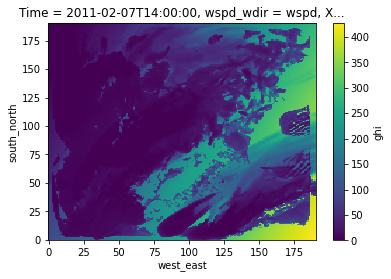

In [11]:
ghi2d = wrfdata.ghi.isel(Time=14)
ghi2d.plot()

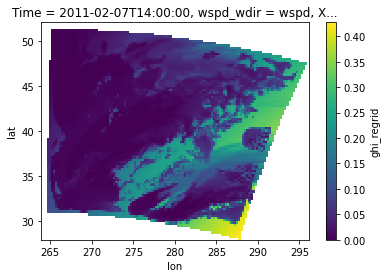

In [12]:
ghi2d = wrfdata.ghi_regrid.isel(Time=14)
ghi2d.plot()

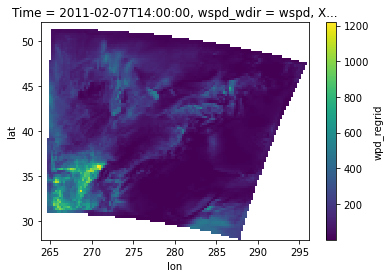

In [13]:
wrf_wpd_regrid
wpd2d = wrfdata.wpd_regrid.isel(Time=14)
wpd2d.plot()

In [28]:
# Now test the function that does the same as the above in optwrf.runwrf
wrfdata_2, eradata_2 = rw.wrf_era5_regrid_xesmf(in_yr, in_mo, wrfdir, eradir)

Overwrite existing file: bilinear_191x191_97x129.nc 
 You can set reuse_weights=True to save computing time.


/Users/swardy9230/opt/anaconda3/envs/runwrf/lib/python3.7/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


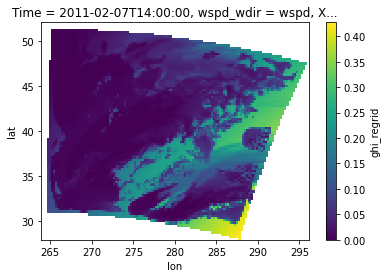

In [29]:
ghi2d = wrfdata_2.ghi_regrid.isel(Time=14)
ghi2d.plot()

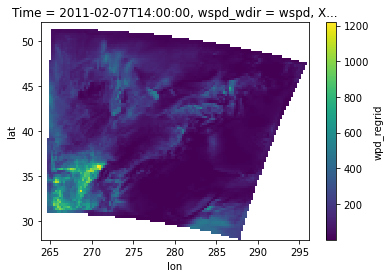

In [30]:
wrf_wpd_regrid
wpd2d = wrfdata_2.wpd_regrid.isel(Time=14)
wpd2d.plot()

In [31]:
eradata_2

<xarray.Dataset>
Dimensions:   (Time: 672, lat: 97, lon: 129, time: 672)
Coordinates:
  * lat       (lat) float64 52.0 51.75 51.5 51.25 51.0 ... 28.75 28.5 28.25 28.0
  * lon       (lon) float64 264.0 264.2 264.5 264.8 ... 295.2 295.5 295.8 296.0
  * time      (time) datetime64[ns] 2011-02-01 ... 2011-02-28T23:00:00
  * Time      (Time) datetime64[ns] 2011-02-01 ... 2011-02-28T23:00:00
Data variables:
    VAR_100U  (time, lat, lon) float32 ...
    VAR_100V  (time, lat, lon) float32 ...
    WPD       (time, lat, lon) float32 174317.23 186448.44 ... 324.84235
    SSRD      (Time, lat, lon) float32 ...
    GHI       (Time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ghi       (Time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    wpd       (time, lat, lon) float32 174.31723 186.44844 ... 0.32484233

In [32]:
wrfdata_2

<xarray.Dataset>
Dimensions:         (Time: 24, bottom_top: 35, lat: 97, lon: 129, south_north: 191, west_east: 191)
Coordinates:
  * Time            (Time) datetime64[ns] 2011-02-07 ... 2011-02-07T23:00:00
  * lon             (lon) float64 264.0 264.2 264.5 264.8 ... 295.5 295.8 296.0
  * lat             (lat) float64 52.0 51.75 51.5 51.25 ... 28.5 28.25 28.0
    wspd_wdir       object ...
    XLONG           (south_north, west_east) float32 ...
    XLAT            (south_north, west_east) float32 ...
    XTIME           (Time) float32 ...
    level           int64 ...
Dimensions without coordinates: bottom_top, south_north, west_east
Data variables:
    Times           (Time) datetime64[ns] ...
    temp_air        (Time, south_north, west_east) float32 ...
    wind_speed_u    (Time, south_north, west_east) float32 ...
    wind_speed_v    (Time, south_north, west_east) float32 ...
    cloud_fraction  (Time, bottom_top, south_north, west_east) float32 ...
    cos_zenith      (Time, south_north, west_east) float32 ...
    dni             (Time, south_north, west_east) float32 ...
    dhi             (Time, south_north, west_east) float32 ...
    ghi             (Time, south_north, west_east) float32 0.0 0.0 ... 0.0 0.0
    wind_speed10    (Time, south_north, west_east) float32 ...
    wind_speed100   (Time, south_north, west_east) float32 ...
    wpd             (Time, south_north, west_east) float32 29141.006 ... 7670.802
    ghi_regrid      (Time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    wpd_regrid      (Time, lat, lon) float64 nan nan nan nan ... nan nan nan nan

In [33]:
ghi_error = abs(wrfdata_2.ghi_regrid - eradata_2.ghi)
ghi_error[0,0,:50]

<xarray.DataArray (lon: 50)>
array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])
Coordinates:
    Time       datetime64[ns] 2011-02-07
  * lon        (lon) float64 264.0 264.2 264.5 264.8 ... 275.5 275.8 276.0 276.2
    lat        float64 52.0
    wspd_wdir  object ...
    XTIME      float32 ...
    level      int64 ...

In [34]:
# To get around xrray nan bug, fill all nan with -1 (since we took the abs(), all the values in our GHI error should be >= 0)
ghi_error_nonan = ghi_error.fillna(-1)
ghi_error_nonan[0,0,:50]

<xarray.DataArray (lon: 50)>
array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.])
Coordinates:
    Time       datetime64[ns] 2011-02-07
  * lon        (lon) float64 264.0 264.2 264.5 264.8 ... 275.5 275.8 276.0 276.2
    lat        float64 52.0
    wspd_wdir  object ...
    XTIME      float32 ...
    level      int64 ...

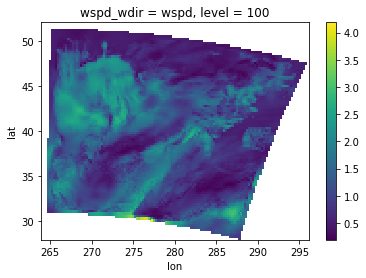

In [35]:
total_ghi_error = ghi_error_nonan.sum(dim='Time')
total_ghi_error = total_ghi_error.where(total_ghi_error > 0)
total_ghi_error.plot()

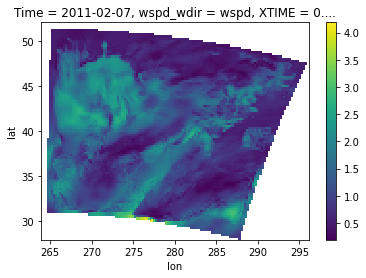

In [36]:
# Manually calculate the sum to make sure that they are the same
for ii in range (0, 24):
    if ii == 0:
        total_ghi_error_man = ghi_error.isel(Time=ii) 
    else:
        total_ghi_error_man += ghi_error.isel(Time=ii) 
total_ghi_error_man.plot()

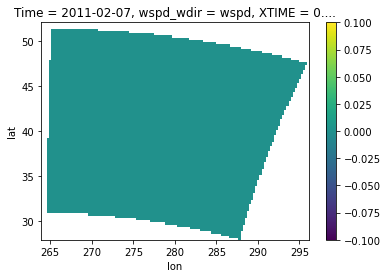

In [37]:
# Compare the manual and hacky bug fix. (All should be nan or 0)
diff = total_ghi_error_man - total_ghi_error_man
diff.plot()

In [46]:
print(f'The difference between the two is: {diff.sum().values}')
print(f'The total GHI error as calculated by the hacky fix: {float(total_ghi_error.sum().values)}')
print(f'The total GHI error as calculated manually: {float(total_ghi_error_man.sum().values)}')

The difference between the two is: 0.0
The total GHI error as calculated by the hacky fix: 10213.991776451854
The total GHI error as calculated manually: 10213.991776451854


In [48]:
# Get the total error now using the function in optwrf.runwrf
wrfdata_2 = rw.wrf_era5_error(wrfdata_2, eradata_2)
wrfdata_2

<xarray.Dataset>
Dimensions:          (Time: 24, bottom_top: 35, lat: 97, lon: 129, south_north: 191, time: 672, west_east: 191)
Coordinates:
  * Time             (Time) datetime64[ns] 2011-02-07 ... 2011-02-07T23:00:00
  * lon              (lon) float64 264.0 264.2 264.5 264.8 ... 295.5 295.8 296.0
  * lat              (lat) float64 52.0 51.75 51.5 51.25 ... 28.5 28.25 28.0
    wspd_wdir        object ...
    XLONG            (south_north, west_east) float32 ...
    XLAT             (south_north, west_east) float32 ...
    XTIME            (Time) float32 ...
    level            int64 ...
  * time             (time) datetime64[ns] 2011-02-01 ... 2011-02-28T23:00:00
Dimensions without coordinates: bottom_top, south_north, west_east
Data variables:
    Times            (Time) datetime64[ns] ...
    temp_air         (Time, south_north, west_east) float32 ...
    wind_speed_u     (Time, south_north, west_east) float32 ...
    wind_speed_v     (Time, south_north, west_east) float32 ...
    cloud_fraction   (Time, bottom_top, south_north, west_east) float32 ...
    cos_zenith       (Time, south_north, west_east) float32 ...
    dni              (Time, south_north, west_east) float32 ...
    dhi              (Time, south_north, west_east) float32 ...
    ghi              (Time, south_north, west_east) float32 0.0 0.0 ... 0.0 0.0
    wind_speed10     (Time, south_north, west_east) float32 ...
    wind_speed100    (Time, south_north, west_east) float32 ...
    wpd              (Time, south_north, west_east) float32 29141.006 ... 7670.802
    ghi_regrid       (Time, lat, lon) float64 nan nan nan nan ... nan nan nan
    wpd_regrid       (Time, lat, lon) float64 nan nan nan nan ... nan nan nan
    ghi_error        (Time, lat, lon) float64 nan nan nan nan ... nan nan nan
    wpd_error        (Time, lat, lon, time) float64 nan nan nan ... nan nan nan
    total_ghi_error  (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    total_wpd_error  (lat, lon, time) float64 nan nan nan nan ... nan nan nan

In [50]:
error = [0, float(wrfdata_2['total_ghi_error'].sum().values), float(wrfdata_2['total_wpd_error'].sum().values)]
error

[0, 10213.991776451854, 48887860697.26696]

In [127]:
# Annual mean daylight fraction 
daylight_factors = []
for jday in range(1, 366):
    daylight_factors.append(ow.helper_functions.daylight_frac(jday))

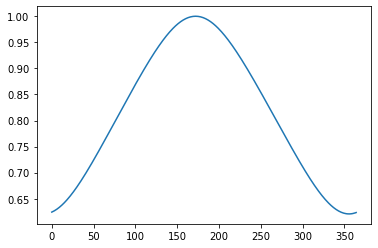

In [128]:
fig, ax = plt.subplots()
ax.plot(daylight_factors)

In [130]:
sum(daylight_factors) / len(daylight_factors)

0.812716796611979

The following function makes use of the NCAR geocat.comp module. Unfortunately, the function I was looking to use, rcm2rgrid, does not yet exist... One day

In [22]:
def wrf_era5_regrid_geocat(in_yr, in_mo, wrfdir='./', eradir='/share/mzhang/jas983/wrf_data/data/ERA5/'):
    """

    :param in_yr:
    :param in_mo:
    :param wrfdir:
    :param eradir:
    :return:

    """
    # WRF file containing source grid
    wrffile = 'wrfout_processed_d01.nc'
    try:
        wrfdata = xr.open_dataset(wrfdir + wrffile)
    except FileNotFoundError:
        print(f'The wrfout file {wrfdir + wrffile} does not exist. Check that your path.')
        wrfdata = None
        eradata = None
        return wrfdata, eradata

    # Get wrf variable(s) to regrid
    wrf_lat = wrfdata.XLAT
    wrf_lon = wrfdata.XLONG

    # Read in and convert GHI from W m-2 to kW m-2
    ghi = wrfdata.ghi
    ghi = ghi / 1000

    # Read in WPD, convert from W m-2 to kW m-2
    wpd = wrfdata.wpd
    wpd = wpd / 1000

    # ERA data file(s)
    erafile = f'ERA5_EastUS_WPD-GHI_{str(in_yr).zfill(4)}-{str(in_mo).zfill(2)}.nc'
    try:
        eradata = xr.open_dataset(eradir + erafile)
    except FileNotFoundError:
        print(f'The wrfout file {eradir + erafile} does not exist. Check that your path.')
        eradata = None
        return wrfdata, eradata

    # Get variables to compare with regridded WRF variables.
    era_lat = eradata.latitude
    era_lon = eradata.longitude

    # Read in ERA_GHI, convert from W m-2 to kW m-2
    era_ghi = eradata.GHI
    era_ghi = era_ghi / 1000

    # Read in ERA_WPD, convert from W m-2 to kW m-2
    era_wpd = eradata.WPD
    era_wpd = era_wpd / 1000

    # Write these back to the xarray dataset
    eradata['ghi'] = era_ghi
    eradata['wpd'] = era_wpd

    # Do the regridding
    wrf_ghi_regrid = geocat.comp.rcm2rgrid(wrf_lat, wrf_lon, ghi, era_lat, era_lon)
    wrf_wpd_regrid = geocat.comp.rcm2rgrid(wrf_lat, wrf_lon, wpd, era_lat, era_lon)

    # Add the regridded variables to the WRF xarray dataset
    wrfdata['ghi_regrid'] = wrf_ghi_regrid
    wrfdata['wpd_regrid'] = wrf_wpd_regrid

    return wrfdata, eradata
